<i>DISCLAIMER:<br>
Bellow code is only for informative purpose, i renounce any responsibility regarding this code and bellow trained model causing loss of money during trading on real market.</i>

# Stock price prediction : NVDA

This page does following:

<b>1. Loading and preparation</b>
- Load data and libraries
- Normalize data based on linear scaling formula
- Split data to train and validation set (train 80%, validation 20%)
- Transform train and validation set into windows, each window has 6 rows (candles), first 5 rows represents formation the model is trained on, the 6th row is label (target price, the model will predict, this is highest price of following week). Windowed data are transformed to tensors for future model training<br>

<b>2. Fun part - model training</b>
- Entry price is High price of last candle in formation
- Model predicts high price of following week
- CNN + LSTM + DNN model is trained and compared to validation dataset used during training
- After model is trained, we let model predict prices on validation dataset<br>

<b>3. Result evaluation</b>
- New dataframe is created with predicted values, normalized data are reverted back to initial values
- We calculate  profit/loss per each trade on validation dataset and final balance is displayed
- Each trade is displayed in chart with target value, predicted value and entry price that trade was entered
- As the last step, prediction of the most recent stock data is made (please refer to page 03_Model_prediction

# 1. Loading and preparation

In [1]:
import tensorflow as tf
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

print("Tensorflow version: ", tf.__version__)

path = "nvda_stock_raw.csv"

data = pd.read_csv(path)
data.tail()

Tensorflow version:  2.7.0


,Date,Open,High,Low,Close,EMA6,EMA12,EMA24,trades
29820,2022-04-11 00:00:00,222.139999,227.770004,211.630005,212.580002,238.995204,245.130077,246.528697,1193
29821,2022-04-18 00:00:00,212.000000,226.699997,195.000000,195.149994,226.468001,237.440834,242.418401,1193
29822,2022-04-25 00:00:00,192.020004,201.279999,182.899994,185.470001,214.754287,229.445321,237.862529,1193
29823,2022-05-02 00:00:00,185.410004,204.000000,179.899994,186.750000,206.753062,222.876810,233.773527,1193
29824,Month,180.339996,196.190002,155.669998,187.199997,NaN,NaN,NaN,1193


<b>Get data and plot chart</b>

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.title("AAPL close price")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
import csv
time_step = []

opens = []
highs = []
lows = []
closes = []
ema1 = []
ema2 = []
ema3 = []

new = []

final = []
with open(path) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
   # next(reader)

    for row in reader:
        #print(row)
        
        time_step.append(row[0])
        opens.append(float(row[1]))
        highs.append(float(row[2]))
        lows.append(float(row[3]))
        closes.append(float(row[4]))
        ema1.append(row[5])
        ema2.append(row[6])
        ema3.append(row[7])

        
#Get series
series = np.array(closes[::])
time = np.array(time_step[::])

#Plot chart
#plt.figure(figsize=(10, 6))
#plot_series(time, series)
print("done")

done


Get data in dataframe and prepare for windowing, we will be getting windows of 4 candles each, thus we need to have dataframe divisible by 4

In [4]:
dicti = {'Date':time,
         'opens':opens,
         'high':highs,
         'low':lows,
         'close':closes,
         'ema6':ema1,
         'ema12':ema2,
         'ema24':ema3}

temp_old = pd.DataFrame(dicti)
temp_old.tail(30)

,Date,opens,high,low,close,ema6,ema12,ema24
29795,2022-04-04 00:00:00,267.279999,275.579987,230.619995,231.190002,249.56128524437523,251.04827289217764,249.4807577273994
29796,2022-04-11 00:00:00,222.139999,227.770004,211.630005,212.580002,238.9952042691408,245.13007734431255,246.52869725569184
29797,2022-04-18 00:00:00,212.000000,226.699997,195.000000,195.149994,226.46800130552467,237.44083373695437,242.41840098695525
29798,2022-04-25 00:00:00,192.020004,201.279999,182.899994,185.470001,214.75428699557565,229.4453210421465,237.8625290056551
29799,Month,185.410004,204.000000,155.669998,188.110001,,,
29800,2021-11-22 00:00:00,335.170013,346.470001,308.799988,315.029999,292.2176096092486,265.1341963081367,234.2454435712369
29801,2021-11-29 00:00:00,323.660004,334.119995,301.299988,306.929993,296.4211476282579,271.5643188262359,240.06020749960047
29802,2021-12-06 00:00:00,298.799988,324.489990,280.380005,301.980011,298.00939430199224,276.2436560816347,245.0137917785387
29803,2021-12-13 00:00:00,302.489990,311.600006,272.500000,278.010010,292.2952844344587,276.5154028022486,247.65348921750558
29804,2021-12-20 00:00:00,273.049988,300.589996,271.450012,296.399994,293.468058566466,279.57457066290027,251.55320959182387


Get dataframe divisible by 6, since <b>5 candles represents formation</b>, 1 candle is label

In [5]:
print("Initial length of dataframe: ",len(temp_old))
formations = int(len(temp_old)/25)
print("Nr of formations: ", formations)
ttl = int(formations*25)
print("New length of dataframe: ",ttl)

Initial length of dataframe:  29825
Nr of formations:  1193
New length of dataframe:  29825


<b>Get final dataframe</b>
- <b>If needed Reshuffling MUST be done here</b>
- get temp dataframe that has excluded Date column
- get new Dates column separately for future reference

In [6]:
initial_df = temp_old.iloc[:ttl,1:]
len_initial = len(initial_df)
print("Len initial_df: ",len_initial)
initial_df.head(2)

Len initial_df:  29825


,opens,high,low,close,ema6,ema12,ema24
0,0.437500,0.488281,0.388021,0.410156,,,
1,0.442708,0.467448,0.395833,0.395833,,,


In [7]:
Dates = temp_old.iloc[:len_initial,0]
Dates.head(2)

0    1999-01-18 00:00:00
1    1999-01-25 00:00:00
Name: Date, dtype: object

In [8]:
initial_df.head(20)

,opens,high,low,close,ema6,ema12,ema24
0,0.437500,0.488281,0.388021,0.410156,,,
1,0.442708,0.467448,0.395833,0.395833,,,
2,0.395833,0.416667,0.360677,0.412760,,,
3,0.415365,0.437500,0.372396,0.434896,,,
4,0.442708,0.460938,0.393229,0.434896,,,
5,0.442708,0.546875,0.414063,0.457031,0.42426199714342755,,
6,0.468750,0.479167,0.411458,0.438802,0.42841628477686927,,
7,0.427083,0.466146,0.416667,0.424479,0.42729134847517725,,
8,0.434896,0.450521,0.420573,0.437500,0.430208106053698,,
9,0.446615,0.447917,0.380208,0.436198,0.4319195032210775,,


<b>We must fill empty values of week candles of ema colls

In [9]:
for row in range(1430):
    if initial_df.iloc[row,4] == "":
        initial_df.iloc[row,4] = initial_df.iloc[row,3]
    if initial_df.iloc[row,5] == "":
        initial_df.iloc[row,5] = initial_df.iloc[row,4]
    if initial_df.iloc[row,6] == "":
        initial_df.iloc[row,6] = initial_df.iloc[row,5]
        

In [10]:
for row in range(24,len(initial_df),25):
    candles = initial_df.iloc[row,:4] 
    mean = np.mean(candles)
    #print(mean)
    #print(candles)

    initial_df.iloc[row,4:initial_df.shape[1]] = float(mean)
    
initial_df['ema24'] = initial_df['ema24'].astype('float64')
initial_df['ema12'] = initial_df['ema12'].astype('float64')
initial_df['ema6'] = initial_df['ema6'].astype('float64')

In [11]:
initial_df.tail(26)

,opens,high,low,close,ema6,ema12,ema24
29799,185.410004,204.000000,155.669998,188.110001,183.297501,183.297501,183.297501
29800,335.170013,346.470001,308.799988,315.029999,292.217610,265.134196,234.245444
29801,323.660004,334.119995,301.299988,306.929993,296.421148,271.564319,240.060207
29802,298.799988,324.489990,280.380005,301.980011,298.009394,276.243656,245.013792
29803,302.489990,311.600006,272.500000,278.010010,292.295284,276.515403,247.653489
29804,273.049988,300.589996,271.450012,296.399994,293.468059,279.574571,251.553210
29805,296.600006,313.299988,293.309998,294.109985,293.651466,281.810788,254.957752
29806,298.149994,307.109985,270.570007,272.470001,287.599619,280.373744,256.358732
29807,265.809998,285.950012,256.440002,269.420013,282.405446,278.688555,257.403634
29808,262.600006,266.380005,232.630005,233.740005,268.501034,271.773393,255.510544


<b>Normalize data</b>

Linear scaling formula: <i>x ′ = ( x − x m i n ) / ( x m a x − x m i n )</i><br>
Reverse linear scaling: <i>x = (x * (maxv-minv)) + minv</i>

Bellow code will take window size which represents formation that is to be traded, and normalize data exactly per window that is alocated. Each window is normalized separately on each other, using linear scaling formula from above

# BATCH SIZE SETTINGS

<b>Set Window Size and Normalize based on windows</b>

Set window size and normalize entire dataset before modelling

In [12]:
window_size = 24+1

batch_size = 64 #Train batchsize

batch_valid = 8 #Valid batchsize

tf.random.set_seed(7788)
np.random.seed(7788)


In [13]:
def Normalize(df,window_size):
    """
    Get dataframe and window_size as an input
    
    Normalize data based on linear scaling formula
    
    save maxv and minv of each window for future reversion
    
    """
    
    print("\nNormalize dataframe \n")
    
    #Initialize dataitems
    counter = 0
    inc = 0
    Highs = []
    Lows = []

    df_norm = pd.DataFrame()

    #Loop through each window separately to normalize
    for row in range(0,len(df),window_size):
        
        counter += 1
        df_temp = pd.DataFrame()


        #Get maxv and minv of window
        while inc < df.shape[1]: 

            #Get max High
            if row + inc<len(df):
                
                Highs.append(df.iloc[row+inc][1])
                Lows.append(df.iloc[row+inc][2])

                inc += 1
            else:
                break

        #reset inc
        inc = 0

        #Save Max and Min
        maxv = max(Highs)
        minv = min(Lows)
        
        #testing
        maxv = np.max(df.iloc[row:row + window_size,:].to_numpy())
        minv = np.min(df.iloc[row:row + window_size,:].to_numpy())
        #print(maxv)
        #print(minv)
        #break
        #Reset 
        Highs = []
        Lows = []

        #Print first 2 windows for checking
        if counter < 3:
            #Print data windowing
            print("\nWindow:" + str(counter) + "\n " + str(df.iloc[row:row + window_size,:]))
            print("\nMax value is ", maxv)
            print("Min value is ", minv)
            print("\n Normalized:\n "+ str((df.iloc[row:row + window_size,:]-minv)/(maxv-minv)))

        #Merge normalized window to new dataframe
        df_temp = (df.iloc[row:row + window_size,:]-minv)/(maxv-minv)
        df_temp['maxv'] = maxv
        df_temp['minv'] = minv

        df_norm = pd.concat([df_norm,df_temp],axis=0)     

    print("\nDone")
    
    return df_norm
    
df_norm = Normalize(initial_df,window_size)


Normalize dataframe 


Window:1
        opens      high       low     close      ema6     ema12     ema24
0   0.437500  0.488281  0.388021  0.410156  0.410156  0.410156  0.410156
1   0.442708  0.467448  0.395833  0.395833  0.395833  0.395833  0.395833
2   0.395833  0.416667  0.360677  0.412760  0.412760  0.412760  0.412760
3   0.415365  0.437500  0.372396  0.434896  0.434896  0.434896  0.434896
4   0.442708  0.460938  0.393229  0.434896  0.434896  0.434896  0.434896
5   0.442708  0.546875  0.414063  0.457031  0.424262  0.424262  0.424262
6   0.468750  0.479167  0.411458  0.438802  0.428416  0.428416  0.428416
7   0.427083  0.466146  0.416667  0.424479  0.427291  0.427291  0.427291
8   0.434896  0.450521  0.420573  0.437500  0.430208  0.430208  0.430208
9   0.446615  0.447917  0.380208  0.436198  0.431920  0.431920  0.431920
10  0.449219  0.459635  0.404948  0.427083  0.430538  0.430538  0.430538
11  0.421875  0.458333  0.395833  0.437500  0.432527  0.428928  0.428928
12  0.432292  0.4

In [14]:
temp_old.head(6)

,Date,opens,high,low,close,ema6,ema12,ema24
0,1999-01-18 00:00:00,0.437500,0.488281,0.388021,0.410156,,,
1,1999-01-25 00:00:00,0.442708,0.467448,0.395833,0.395833,,,
2,1999-02-01 00:00:00,0.395833,0.416667,0.360677,0.412760,,,
3,1999-02-08 00:00:00,0.415365,0.437500,0.372396,0.434896,,,
4,1999-02-15 00:00:00,0.442708,0.460938,0.393229,0.434896,,,
5,1999-02-22 00:00:00,0.442708,0.546875,0.414063,0.457031,0.42426199714342755,,


Check <b>not normalized</b> dataframe initial_df

In [15]:
initial_df.tail(6)

,opens,high,low,close,ema6,ema12,ema24
29819,267.279999,275.579987,230.619995,231.190002,249.561285,251.048273,249.480758
29820,222.139999,227.770004,211.630005,212.580002,238.995204,245.130077,246.528697
29821,212.000000,226.699997,195.000000,195.149994,226.468001,237.440834,242.418401
29822,192.020004,201.279999,182.899994,185.470001,214.754287,229.445321,237.862529
29823,185.410004,204.000000,179.899994,186.750000,206.753062,222.876810,233.773527
29824,180.339996,196.190002,155.669998,187.199997,179.849998,179.849998,179.849998


Check <b>normalized</b> dataframe df_norm

In [16]:
df_norm.tail(6)

,opens,high,low,close,ema6,ema12,ema24,maxv,minv
29819,0.584958,0.628459,0.392820,0.395807,0.492093,0.499886,0.491671,346.470001,155.669998
29820,0.348375,0.377883,0.293291,0.298270,0.436715,0.468868,0.476199,346.470001,155.669998
29821,0.295231,0.372275,0.206132,0.206918,0.371059,0.428568,0.454656,346.470001,155.669998
29822,0.190514,0.239046,0.142715,0.156184,0.309666,0.386663,0.430778,346.470001,155.669998
29823,0.155870,0.253302,0.126992,0.162893,0.267731,0.352237,0.409348,346.470001,155.669998
29824,0.129298,0.212369,0.000000,0.165252,0.126730,0.126730,0.126730,346.470001,155.669998


We have added additional columns maxv and minv to each row, this is needed due to future need to revert normalized values back to its initial ones.

<b>Split normalized data to train and validation set</b>

In [17]:
print("dfnorm ",len(df_norm))
ttl = len(df_norm)/window_size

print("df_norm / windowsize: ",ttl)

new_ttl = ttl*window_size
print("total len: ", new_ttl)

trainsubset = new_ttl*0.8,0
print("raw trainsubset: ",trainsubset)
trainsubset = round(new_ttl*0.8,0)
print("get 80% of train set: ", trainsubset)

train_windows = round(trainsubset/window_size)
print("total windows of 80% train set: ",train_windows)

ttl_xtrain = train_windows*window_size
print("\ntotal x_train: ",ttl_xtrain)

print("total x_val: ",(-ttl_xtrain)+len(df_norm))

dfnorm  29825
df_norm / windowsize:  1193.0
total len:  29825.0
raw trainsubset:  (23860.0, 0)
get 80% of train set:  23860.0
total windows of 80% train set:  954

total x_train:  23850
total x_val:  5975


In [18]:
print("ttl x_train,",ttl_xtrain)
split = int(ttl_xtrain)

time_train = time[:split]
x_train = df_norm[:split]
time_valid = time[split:]
x_valid = df_norm[split:]
print("x_valid window",len(x_valid)/25)

ttl x_train, 23850
x_valid window 239.0


<b>Display normalized train set</b>

In [19]:
x_valid.head(20)

,opens,high,low,close,ema6,ema12,ema24,maxv,minv
23850,0.055160,0.072659,0.037081,0.047862,0.039841,0.038347,0.000000,54.6675,24.522185
23851,0.051843,0.268211,0.035008,0.247147,0.099071,0.070470,0.019772,54.6675,24.522185
23852,0.260996,0.332815,0.240180,0.314404,0.160595,0.107998,0.043342,54.6675,24.522185
23853,0.329083,0.391365,0.311999,0.362836,0.218378,0.147204,0.068902,54.6675,24.522185
23854,0.378262,0.405629,0.364578,0.377764,0.263917,0.182675,0.093611,54.6675,24.522185
23855,0.372290,0.583932,0.368393,0.427191,0.310567,0.220293,0.120297,54.6675,24.522185
23856,0.396341,0.470067,0.365075,0.443943,0.348674,0.254701,0.146189,54.6675,24.522185
23857,0.458788,0.527870,0.457213,0.462271,0.381131,0.286635,0.171476,54.6675,24.522185
23858,0.473301,0.485243,0.376603,0.385394,0.382349,0.301828,0.188589,54.6675,24.522185
23859,0.389457,0.409776,0.335801,0.403639,0.388432,0.317491,0.205793,54.6675,24.522185


In [20]:
x_train_extremes = x_train.iloc[:,7:].copy()
print("Len x_train_extremes: ",len(x_train_extremes))
x_train_extremes.head(1)

Len x_train_extremes:  23850


,maxv,minv
0,0.546875,0.333333


In [21]:
x_valid_extremes = x_valid.iloc[:,7:].copy()
print("len x_valid_extremes: ",len(x_valid_extremes))
x_valid_extremes.head(1)

len x_valid_extremes:  5975


,maxv,minv
23850,54.6675,24.522185


<b>Get x_train and x_valid without extreme minv maxv values</b>

In [22]:
x_valid = x_valid.iloc[:,:7].copy()
x_train = x_train.iloc[:,:7].copy()
x_train.head(26)

,opens,high,low,close,ema6,ema12,ema24
0,0.487806,0.725609,0.256100,0.359756,0.359756,0.359756,0.359756
1,0.512194,0.628050,0.292682,0.292682,0.292682,0.292682,0.292682
2,0.292682,0.390247,0.128050,0.371950,0.371950,0.371950,0.371950
3,0.384149,0.487806,0.182929,0.475611,0.475611,0.475611,0.475611
4,0.512194,0.597564,0.280488,0.475611,0.475611,0.475611,0.475611
5,0.512194,1.000000,0.378052,0.579268,0.425813,0.425813,0.425813
6,0.634147,0.682929,0.365853,0.493903,0.445267,0.445267,0.445267
7,0.439024,0.621953,0.390247,0.426829,0.439999,0.439999,0.439999
8,0.475611,0.548782,0.408538,0.487806,0.453658,0.453658,0.453658
9,0.530491,0.536588,0.219512,0.481709,0.461673,0.461673,0.461673


<b>Get windowed train dataset into tensors</b>

we have to make sure we get tensors with exact windows that have been normalized in previous step, thus we have to shift it to size of window, so that there are taken <b>only</b> respective windows to tensor 

Also we are NOT shuffling dataset here, reshufling can be only done  at the beginning before normalization

In [23]:
print("window size: ",window_size)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Get windowed train dataset based on inputs
    """
    
    #This code must be trigered only when using Conv1D layer as input
    #series = tf.expand_dims(series, axis=-1)
    
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    
    #ds = ds.shuffle(shuffle_buffer)
    
    ds = ds.map(lambda w: (w[:-1], w[-1:, 1]))
    
    return ds.batch(batch_size).prefetch(1)

#Initiate
tf.keras.backend.clear_session()
shuffle_buffer_size = len(x_train)


train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print("\nDone")

window size:  25

Done


<b>Check window and compare with dataframe x train</b>

In [24]:
for batch in train_set:
    print(batch)
    break

(<tf.Tensor: shape=(64, 24, 7), dtype=float64, numpy=
array([[[0.48780571, 0.72560909, 0.25609952, ..., 0.35975602,
         0.35975602, 0.35975602],
        [0.51219429, 0.62804976, 0.29268245, ..., 0.29268245,
         0.29268245, 0.29268245],
        [0.29268245, 0.39024652, 0.12804983, ..., 0.37195024,
         0.37195024, 0.37195024],
        ...,
        [0.1676861 , 0.19512326, 0.03658768, ..., 0.12273034,
         0.18969584, 0.18969584],
        [0.08536972, 0.13414701, 0.04115819, ..., 0.11902404,
         0.17739775, 0.17739775],
        [0.16463751, 0.33536731, 0.09756407, ..., 0.1808364 ,
         0.20170076, 0.3076739 ]],

       [[0.51219429, 0.62804976, 0.29268245, ..., 0.29268245,
         0.29268245, 0.29268245],
        [0.29268245, 0.39024652, 0.12804983, ..., 0.37195024,
         0.37195024, 0.37195024],
        [0.38414934, 0.48780571, 0.1829289 , ..., 0.47561135,
         0.47561135, 0.47561135],
        ...,
        [0.08536972, 0.13414701, 0.04115819, ..., 0.11

In [25]:
x_train.head(12)

,opens,high,low,close,ema6,ema12,ema24
0,0.487806,0.725609,0.256100,0.359756,0.359756,0.359756,0.359756
1,0.512194,0.628050,0.292682,0.292682,0.292682,0.292682,0.292682
2,0.292682,0.390247,0.128050,0.371950,0.371950,0.371950,0.371950
3,0.384149,0.487806,0.182929,0.475611,0.475611,0.475611,0.475611
4,0.512194,0.597564,0.280488,0.475611,0.475611,0.475611,0.475611
5,0.512194,1.000000,0.378052,0.579268,0.425813,0.425813,0.425813
6,0.634147,0.682929,0.365853,0.493903,0.445267,0.445267,0.445267
7,0.439024,0.621953,0.390247,0.426829,0.439999,0.439999,0.439999
8,0.475611,0.548782,0.408538,0.487806,0.453658,0.453658,0.453658
9,0.530491,0.536588,0.219512,0.481709,0.461673,0.461673,0.461673


<b>Get windowed validation dataset into tensors</b>

We have to prepare validation dataset manually to use in our modeling since keras does not allow to use evaluation dataset created via tf.data.Dataset, thus we have to do basic preprocessing manually and pass features and labels separately to model (this was done automaticaly via tf.dataset for train set in previous steps)

In [26]:
print("Len x_valid: ",len(x_valid))
print(len(x_valid)/window_size)
x_valid.head(10)

Len x_valid:  5975
239.0


,opens,high,low,close,ema6,ema12,ema24
23850,0.055160,0.072659,0.037081,0.047862,0.039841,0.038347,0.000000
23851,0.051843,0.268211,0.035008,0.247147,0.099071,0.070470,0.019772
23852,0.260996,0.332815,0.240180,0.314404,0.160595,0.107998,0.043342
23853,0.329083,0.391365,0.311999,0.362836,0.218378,0.147204,0.068902
23854,0.378262,0.405629,0.364578,0.377764,0.263917,0.182675,0.093611
23855,0.372290,0.583932,0.368393,0.427191,0.310567,0.220293,0.120297
23856,0.396341,0.470067,0.365075,0.443943,0.348674,0.254701,0.146189
23857,0.458788,0.527870,0.457213,0.462271,0.381131,0.286635,0.171476
23858,0.473301,0.485243,0.376603,0.385394,0.382349,0.301828,0.188589
23859,0.389457,0.409776,0.335801,0.403639,0.388432,0.317491,0.205793


In [27]:
def Window_validation(x_valid,window_size,batch_valid):
    """
    create tensors of validation dataset
    """
    
    #Initialize data items
    counter = 0
    win = []
    ttl = []
    labels = []
    features = []
    temp_labels = []
    window = window_size
    x_valid_np =  x_valid.to_numpy()


    #Loop row by row and skip each window in dataset (due to normalization that was done before)
    for item in range(0,len(x_valid),window_size):

        #Validation to not exceed the end of xvalid
        if item + window > len(x_valid):
            print(item + window)
            break

        #Get features of window
        while counter != window:
            if (counter+item) <= len(x_valid):
                win.append(x_valid_np[counter+item])
            counter += 1

        if counter==window:
            counter = 0

        if counter+item>len(x_valid)-1:
            break

        #Get labels
        temp_labels.append(x_valid_np[item+window_size-1][1]) 

        labels.append(temp_labels)
        features.append(win[:-1])

        win = []
        temp_labels = []

    features = np.expand_dims(features,axis=-1)
    features = np.squeeze(features)

    val_dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    val_dataset = val_dataset.batch(batch_valid)

    print("\nDone")
    
    return val_dataset, labels

val_dataset,labels = Window_validation(x_valid,window_size,batch_valid)


Done


<b>Check window and compare with dataframe x valid</b>

In [28]:
x_valid.head(25)

,opens,high,low,close,ema6,ema12,ema24
23850,0.055160,0.072659,0.037081,0.047862,0.039841,0.038347,0.000000
23851,0.051843,0.268211,0.035008,0.247147,0.099071,0.070470,0.019772
23852,0.260996,0.332815,0.240180,0.314404,0.160595,0.107998,0.043342
23853,0.329083,0.391365,0.311999,0.362836,0.218378,0.147204,0.068902
23854,0.378262,0.405629,0.364578,0.377764,0.263917,0.182675,0.093611
23855,0.372290,0.583932,0.368393,0.427191,0.310567,0.220293,0.120297
23856,0.396341,0.470067,0.365075,0.443943,0.348674,0.254701,0.146189
23857,0.458788,0.527870,0.457213,0.462271,0.381131,0.286635,0.171476
23858,0.473301,0.485243,0.376603,0.385394,0.382349,0.301828,0.188589
23859,0.389457,0.409776,0.335801,0.403639,0.388432,0.317491,0.205793


In [29]:
for batch in val_dataset:
    print(batch)
    break
batch_size*4

(<tf.Tensor: shape=(8, 24, 7), dtype=float64, numpy=
array([[[0.05515996, 0.07265854, 0.03708086, ..., 0.03984078,
         0.03834709, 0.        ],
        [0.05184268, 0.26821127, 0.03500757, ..., 0.09907104,
         0.0704701 , 0.01977174],
        [0.26099626, 0.33281508, 0.24018046, ..., 0.16059482,
         0.10799843, 0.04334234],
        ...,
        [0.66064379, 0.67706422, 0.59769872, ..., 0.62567344,
         0.56739114, 0.45080064],
        [0.68593797, 0.69588974, 0.65442392, ..., 0.64407662,
         0.58626705, 0.46994335],
        [0.70244128, 0.80370085, 0.69613852, ..., 0.68871205,
         0.61919529, 0.49637193]],

       [[0.03271783, 0.25345069, 0.01554315, ..., 0.08089882,
         0.05172098, 0.        ],
        [0.24609015, 0.3193576 , 0.22485449, ..., 0.14366356,
         0.09000628, 0.02404603],
        [0.31555042, 0.37908828, 0.29812194, ..., 0.20261236,
         0.1300029 , 0.0501211 ],
        ...,
        [0.67960316, 0.68975567, 0.64745346, ..., 0.636

256

In [30]:
print("Len Labels: ",len(labels))
len(x_valid)/25

Len Labels:  239


239.0

By above code we have preprocessed and divided dataset into train set and validation set. Both sets were transformed into tensors, those tensors will be used in following training part.

# 2. Fun part - model training

<b>Define callbacks</b>

Callbacks used in our model to improve training

In [31]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(monitor='loss',patience=6,mode='min', restore_best_weights=True)#

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=1)

model_checkpoint = ModelCheckpoint(monitor='loss', 
                             filepath='./nvda_80_model_checkpoint.h5', 
                             save_best_only=True)

callbacks = [early_stopping,reduce_lr,model_checkpoint]

<b>Define customized loss function</b>

Customized loss function must be defined in order to have better model performance

In [32]:
def sign_penalty(y_true,y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred,0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                   )
    
    return(tf.reduce_mean(loss,axis=-1))

tf.keras.losses.sign_penalty = sign_penalty

In [34]:
# model = tf.keras.models.load_model('nvda_80_model_checkpoint.h5', custom_objects={'sign_penalty': sign_penalty} )
# model

<b>Get Model</b>

In [115]:
tf.random.set_seed(7788)

model = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D(filters=256, kernel_size=10,
                      strides=1, padding="same",
                      activation=tf.nn.selu,
                      input_shape=[None, 7]),
#     tf.keras.layers.Conv1D(filters=512, kernel_size=10,
#                       strides=1, padding="same",
#                       activation=tf.nn.selu,
#                       input_shape=[None, 7]),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    #tf.keras.layers.Dropout(0.2),   
    tf.keras.layers.Dense(1024, activation=tf.nn.selu),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation=tf.nn.selu),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation=tf.nn.selu),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation=tf.nn.selu),   
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation=tf.nn.selu),
    tf.keras.layers.Dense(16, activation=tf.nn.selu),
    tf.keras.layers.Dense(4, activation=tf.nn.selu),
    tf.keras.layers.Dense(3, activation=tf.nn.selu), #4
    tf.keras.layers.Dense(1,activation=tf.nn.relu),
])

#optimizer1 = tf.keras.optimizers.SGD(learning_rate=10e-7, momentum=0.9)
#optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
#optimizer3 = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
#optimizer4 = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name='Adadelta')

optimizer5 = tf.keras.optimizers.Adagrad(learning_rate=0.0001, initial_accumulator_value=0.1, epsilon=1e-07,name='Adagrad')

#    name, gradient_aggregator=None, gradient_transformers=None)


model.compile(loss=sign_penalty,
              optimizer=optimizer5,
              )

model.fit(train_set, epochs=120,callbacks=[callbacks],validation_data=val_dataset)


Epoch 1/120
15/15 [==============================] - 90s 3s/step - loss: 0.1085 - val_loss: 0.0545 - lr: 1.0000e-04
Epoch 2/120
15/15 [==============================] - 29s 2s/step - loss: 0.0724 - val_loss: 0.0470 - lr: 1.0000e-04
Epoch 3/120
15/15 [==============================] - 27s 2s/step - loss: 0.0629 - val_loss: 0.0411 - lr: 1.0000e-04
Epoch 4/120
15/15 [==============================] - 27s 2s/step - loss: 0.0562 - val_loss: 0.0364 - lr: 1.0000e-04
Epoch 5/120
15/15 [==============================] - 28s 2s/step - loss: 0.0511 - val_loss: 0.0331 - lr: 1.0000e-04
Epoch 6/120
15/15 [==============================] - 27s 2s/step - loss: 0.0473 - val_loss: 0.0308 - lr: 1.0000e-04
Epoch 7/120
15/15 [==============================] - 27s 2s/step - loss: 0.0445 - val_loss: 0.0293 - lr: 1.0000e-04
Epoch 8/120
15/15 [==============================] - 26s 2s/step - loss: 0.0425 - val_loss: 0.0281 - lr: 1.0000e-04
Epoch 9/120
15/15 [==============================] - 31s 2s/step - loss:

15/15 [==============================] - 28s 2s/step - loss: 0.0277 - val_loss: 0.0200 - lr: 1.0000e-04
Epoch 72/120
15/15 [==============================] - 28s 2s/step - loss: 0.0277 - val_loss: 0.0200 - lr: 1.0000e-04
Epoch 73/120
15/15 [==============================] - 30s 2s/step - loss: 0.0276 - val_loss: 0.0200 - lr: 1.0000e-04
Epoch 74/120
15/15 [==============================] - 30s 2s/step - loss: 0.0276 - val_loss: 0.0200 - lr: 1.0000e-04
Epoch 75/120
15/15 [==============================] - 31s 2s/step - loss: 0.0275 - val_loss: 0.0199 - lr: 1.0000e-04
Epoch 76/120
15/15 [==============================] - 29s 2s/step - loss: 0.0274 - val_loss: 0.0199 - lr: 1.0000e-04
Epoch 77/120
15/15 [==============================] - 31s 2s/step - loss: 0.0274 - val_loss: 0.0199 - lr: 1.0000e-04
Epoch 78/120
15/15 [==============================] - 28s 2s/step - loss: 0.0273 - val_loss: 0.0199 - lr: 1.0000e-04
Epoch 79/120
15/15 [==============================] - 31s 2s/step - loss: 0.0

In [35]:
# Best Trainint Result
# Epoch 102/120
# 15/15 [==============================] - 24s 2s/step - loss: 0.0273 - val_loss: 0.0213 - lr: 8.1920e-14

# model = tf.keras.models.load_model('nvda_80_model_checkpoint.h5', custom_objects={'sign_penalty': sign_penalty} )
# model

# 3. Result evaluation

<b>Make predictions on validation set</b>

window size must be subtracted by 1, since we are doing just predictions, we do not need extra position for label as was required in previous steps when we trained model. We get windowed validation set just for our formation which is consisted of 3 candles

In [35]:
print("Len Xvalid: ", len(x_valid))
print("raw ttl window: ",len(x_valid)/window_size)
ttl_windows = round(int(len(x_valid)/window_size))
print("x valid / window_size: ",ttl_windows)
ttl_candles = ttl_windows*window_size
print("Required length of x_valid: ",ttl_candles)
print("window size: ",window_size)

Len Xvalid:  5975
raw ttl window:  239.0
x valid / window_size:  239
Required length of x_valid:  5975
window size:  25


In [36]:
x_valid_final = x_valid.iloc[:,:].copy()
print("len x valid final: ",len(x_valid_final))
x_valid_final.head(10)
x_valid_final.iloc[4:7,:]
x_valid_final.head(6)

len x valid final:  5975


,opens,high,low,close,ema6,ema12,ema24
23850,0.055160,0.072659,0.037081,0.047862,0.039841,0.038347,0.000000
23851,0.051843,0.268211,0.035008,0.247147,0.099071,0.070470,0.019772
23852,0.260996,0.332815,0.240180,0.314404,0.160595,0.107998,0.043342
23853,0.329083,0.391365,0.311999,0.362836,0.218378,0.147204,0.068902
23854,0.378262,0.405629,0.364578,0.377764,0.263917,0.182675,0.093611
23855,0.372290,0.583932,0.368393,0.427191,0.310567,0.220293,0.120297


Define cusomized function to predict labels based on input, we are feeding to model only 5 rows at a time as formation for prediction

In [37]:
def model_forecast(model, series, window_size):
    """
    Get model, data and window size as an input. 
    Make prediction window is subtracted by 1, since we do not need label in window, 
    label value is skipped
    """
    c = 0
    
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size-1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    
    #This block of code will print out data on which is made prediction
    for item in ds:
        c += 1
        if c <3:
            print("\n"+str(c)+ " prediction:\n ",item)
        else:
            break
            
    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    
    return forecast

In [38]:
x_valid_final.head(24)

,opens,high,low,close,ema6,ema12,ema24
23850,0.055160,0.072659,0.037081,0.047862,0.039841,0.038347,0.000000
23851,0.051843,0.268211,0.035008,0.247147,0.099071,0.070470,0.019772
23852,0.260996,0.332815,0.240180,0.314404,0.160595,0.107998,0.043342
23853,0.329083,0.391365,0.311999,0.362836,0.218378,0.147204,0.068902
23854,0.378262,0.405629,0.364578,0.377764,0.263917,0.182675,0.093611
23855,0.372290,0.583932,0.368393,0.427191,0.310567,0.220293,0.120297
23856,0.396341,0.470067,0.365075,0.443943,0.348674,0.254701,0.146189
23857,0.458788,0.527870,0.457213,0.462271,0.381131,0.286635,0.171476
23858,0.473301,0.485243,0.376603,0.385394,0.382349,0.301828,0.188589
23859,0.389457,0.409776,0.335801,0.403639,0.388432,0.317491,0.205793


In [39]:
forecast = model_forecast(model, x_valid_final, window_size)

print("\nLen Forecast: ",len(forecast))
print("Len Xvalid: ", len(x_valid))
#x_test = x_valid[window_size:]
#print("Len x_test",len(x_test))

forecast2 = np.squeeze(forecast)
forecast2


1 prediction:
  tf.Tensor(
[[0.05515996 0.07265854 0.03708086 0.047862   0.03984078 0.03834709
  0.        ]
 [0.05184268 0.26821127 0.03500757 0.24714669 0.09907104 0.0704701
  0.01977174]
 [0.26099626 0.33281508 0.24018046 0.31440425 0.16059482 0.10799843
  0.04334234]
 [0.32908318 0.39136479 0.31199928 0.36283629 0.21837809 0.14720426
  0.06890185]
 [0.37826157 0.40562904 0.36457791 0.377764   0.26391692 0.18267499
  0.09361082]
 [0.37229049 0.58393204 0.36839269 0.42719131 0.31056675 0.22029288
  0.12029726]
 [0.39634074 0.47006695 0.36507548 0.44394341 0.34867437 0.25470066
  0.14618895]
 [0.45878824 0.5278703  0.45721252 0.46227135 0.38113065 0.28663461
  0.17147555]
 [0.47330128 0.48524345 0.37660297 0.3853937  0.38234866 0.30182832
  0.188589  ]
 [0.38945739 0.40977562 0.33580062 0.40363863 0.38843151 0.31749144
  0.20579297]
 [0.42835235 0.5656871  0.41956149 0.55449128 0.43587716 0.35395296
  0.23368883]
 [0.56593589 0.59056659 0.52422129 0.58061482 0.47723078 0.38882401
  0

array([0.88701105, 0.8823967 , 0.8776256 , 0.87865233, 0.8799751 ,
       0.88143563, 0.88043416, 0.87471735, 0.8595795 , 0.8636461 ,
       0.86689794, 0.8844334 , 0.890432  , 0.8888873 , 0.88375324,
       0.8856425 , 0.8813673 , 0.8768285 , 0.87559044, 0.87617356,
       0.8711113 , 0.86705506, 0.8629252 , 0.8610835 , 0.8571664 ,
       0.8502214 , 0.8640461 , 0.86285925, 0.8534993 , 0.8488073 ,
       0.856261  , 0.8487492 , 0.83410484, 0.82226473, 0.81273997,
       0.8189482 , 0.82181764, 0.8237082 , 0.8346919 , 0.8396541 ,
       0.84767854, 0.87423104, 0.9102659 , 0.91895604, 0.9055234 ,
       0.89495057, 0.8882865 , 0.899041  , 0.8893159 , 0.8754847 ,
       0.74779105, 0.6510297 , 0.63328695, 0.5554161 , 0.4583683 ,
       0.4366342 , 0.41537938, 0.38879356, 0.35485724, 0.32607266,
       0.30364403, 0.283192  , 0.2621654 , 0.24475406, 0.23548274,
       0.23473184, 0.24334663, 0.25784624, 0.27535143, 0.29970434,
       0.3386567 , 0.38506338, 0.43364713, 0.48026916, 0.52872

<b>Make check whether predicted values from forecast function are correct</b>

In [40]:
data = x_valid.iloc[:48,:]
data['Counter'] = [x for x in range(len(data))]
data.head(24)
#x_valid.head(24)

<ipython-input-40-d43a7fa24042>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Counter'] = [x for x in range(len(data))]


,opens,high,low,close,ema6,ema12,ema24,Counter
23850,0.055160,0.072659,0.037081,0.047862,0.039841,0.038347,0.000000,0
23851,0.051843,0.268211,0.035008,0.247147,0.099071,0.070470,0.019772,1
23852,0.260996,0.332815,0.240180,0.314404,0.160595,0.107998,0.043342,2
23853,0.329083,0.391365,0.311999,0.362836,0.218378,0.147204,0.068902,3
23854,0.378262,0.405629,0.364578,0.377764,0.263917,0.182675,0.093611,4
23855,0.372290,0.583932,0.368393,0.427191,0.310567,0.220293,0.120297,5
23856,0.396341,0.470067,0.365075,0.443943,0.348674,0.254701,0.146189,6
23857,0.458788,0.527870,0.457213,0.462271,0.381131,0.286635,0.171476,7
23858,0.473301,0.485243,0.376603,0.385394,0.382349,0.301828,0.188589,8
23859,0.389457,0.409776,0.335801,0.403639,0.388432,0.317491,0.205793,9


In [ ]:
pr = x_valid.iloc[:24,:].to_numpy()
#pr = x_valid_final.head(24).to_numpy()
print(len(pr))
pr = np.array([pr])
pr = np.array([pr])

pred = tf.data.Dataset.from_tensor_slices(pr)
predict = model.predict(pred)
print("Raw prediction: ",predict)

24


Both our prediction above match with first two prediction that was predicted via function forecasts

<b>Print and compare both labels and forecasts</b>

In [ ]:
#print(len(x_test))
print(len(forecast2))
print("\nPrint forecast: \n",forecast2)

In [ ]:
labels = np.squeeze(labels)
print(len(labels))
print("\nPrint labels: \n",labels)

<b>Add model predictions to initial dataframe</b>

Modify y prediction array with predicted values, there must be added additional np.nan to each position that is not prediction. This array will be appended to initial df with all predictions our model has made.

In [43]:
y_prediction = []
y_labels = []
counter = 0

for item in range(len(forecast2)):

    while counter < window_size-1:
        y_prediction.append(np.nan)
        y_labels.append(np.nan)
        counter += 1
        
        if counter == window_size-1:
            y_prediction.append(forecast2[item])
            y_labels.append(labels[item])
    counter = 0
    
print("Len y_prediction: ",len(y_prediction))  
print("Len y_labels: ",len(y_labels))
y_labels = np.squeeze(y_labels)
y_prediction

Len y_prediction:  5975
Len y_labels:  5975


[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.88701105,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.8823967,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.8776256,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.87865233,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.8799751,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.88143563,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 

In [44]:
dicti = {'labels':y_labels,
         'prediction':y_prediction,
        'In':[counter2 for counter2 in range(len(y_prediction))]
        }

prediction_df = pd.DataFrame(dicti)
prediction_df = prediction_df.set_index('In')
prediction_df.tail(10)

,labels,prediction
In,,
5965,NaN,NaN
5966,NaN,NaN
5967,NaN,NaN
5968,NaN,NaN
5969,NaN,NaN
5970,NaN,NaN
5971,NaN,NaN
5972,NaN,NaN
5973,NaN,NaN


Extreme values are needed due to future reversion of normalized data

In [45]:
x_valid_extremes["In"] = np.arange(len(x_valid))
x_valid_extremes = x_valid_extremes.set_index('In')
x_valid_extremes.head(3)

,maxv,minv
In,,
0,54.6675,24.522185
1,54.6675,24.522185
2,54.6675,24.522185


In [46]:
print("x_valid len: ",len(x_valid))
print("x_train len: ",len(x_train))
x_valid['In'] = np.arange(len(x_valid))
x_valid = x_valid.set_index('In')
x_valid.head(3)

x_valid len:  5975
x_train len:  23850


,opens,high,low,close,ema6,ema12,ema24
In,,,,,,,
0,0.055160,0.072659,0.037081,0.047862,0.039841,0.038347,0.000000
1,0.051843,0.268211,0.035008,0.247147,0.099071,0.070470,0.019772
2,0.260996,0.332815,0.240180,0.314404,0.160595,0.107998,0.043342


<b>Merge togeher both x_valid and y_predictions</b>

In [47]:
df_valid_norm = pd.concat([x_valid,prediction_df,x_valid_extremes],axis=1)
print(df_valid_norm.shape)
df_valid_norm.tail(5)

(5975, 11)


,opens,high,low,close,ema6,ema12,ema24,labels,prediction,maxv,minv
In,,,,,,,,,,,
5970,0.348375,0.377883,0.293291,0.298270,0.436715,0.468868,0.476199,NaN,NaN,346.470001,155.669998
5971,0.295231,0.372275,0.206132,0.206918,0.371059,0.428568,0.454656,NaN,NaN,346.470001,155.669998
5972,0.190514,0.239046,0.142715,0.156184,0.309666,0.386663,0.430778,NaN,NaN,346.470001,155.669998
5973,0.155870,0.253302,0.126992,0.162893,0.267731,0.352237,0.409348,NaN,NaN,346.470001,155.669998
5974,0.129298,0.212369,0.000000,0.165252,0.126730,0.126730,0.126730,0.212369,0.563166,346.470001,155.669998


Display initial <b>not normalized</b> validated dataframe

In [48]:
initial_df.iloc[len(x_train):,:].head(4)

,opens,high,low,close,ema6,ema12,ema24
23850,26.184999,26.712500,25.639999,25.965000,25.723198,25.678170,24.522185
23851,26.084999,32.607498,25.577499,31.972500,27.508713,26.646529,25.118210
23852,32.389999,34.555000,31.762501,34.000000,29.363366,27.777832,25.828754
23853,34.442501,36.320000,33.927502,35.459999,31.105261,28.959704,26.599253


Display <b>normalized</b> validated dataframe

In [49]:
df_valid_norm.head(4)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,maxv,minv
In,,,,,,,,,,,
0,0.055160,0.072659,0.037081,0.047862,0.039841,0.038347,0.000000,NaN,NaN,54.6675,24.522185
1,0.051843,0.268211,0.035008,0.247147,0.099071,0.070470,0.019772,NaN,NaN,54.6675,24.522185
2,0.260996,0.332815,0.240180,0.314404,0.160595,0.107998,0.043342,NaN,NaN,54.6675,24.522185
3,0.329083,0.391365,0.311999,0.362836,0.218378,0.147204,0.068902,NaN,NaN,54.6675,24.522185


<b>Revert normalized VALIDATION data back to standard ones</b>

Reverse linear scaling: x = (x * (maxv-minv)) + minv

In [50]:
def RevertNorm(df_final,window_size):
    
    ""
    #Initialize dataitems
    counter = 0
    inc = 0
    Highs = []
    Lows = []

    df_rev = pd.DataFrame()

    #Loop through each window separately to normalize
    for row in range(0,len(df_final),window_size):

        #print("\nCurrent row is: ",row)
        counter += 1
        df_temp = pd.DataFrame()


        #Get maxv and minv of window
        while inc < df_final.shape[1]: 

            #Break for loop in case of excession
            if row + inc<len(df_final):

                inc += 1
            else:
                break

        #reset inc
        inc = 0

        maxv = np.squeeze(df_final.iloc[row,9:-1].to_numpy())
        minv = np.squeeze(df_final.iloc[row,10:].to_numpy())
        
        #########################
        #Debugging block
        
        #print("maxv: ",maxv)
        #print("minv: ",minv)
        #break
        #Print first 2 windows for checking
        #if counter < 3:
        #    #Print data windowing
        #    print("\nWindow:" + str(counter) + "\n " + str(df_final.iloc[row:row + window_size]))
        #    print("\nMax value is ", maxv)
        #    print("Min value is ", minv)
        #    print("\n Reverted:\n "+ str((df_final.iloc[row:row + window_size]*(maxv-minv))+minv))
        ##############################
        
        #Merge normalized window to new dataframe
        df_temp = (df_final.iloc[row:row + window_size,:]*(maxv-minv))+minv

        df_rev = pd.concat([df_rev,df_temp],axis=0)     
    
    #get final df
    df_rev = df_rev.iloc[:,:9]
    
    print("\nDone")
    
    return df_rev

df_rev = RevertNorm(df_valid_norm,window_size)
df_rev.head(4)


Done


,opens,high,low,close,ema6,ema12,ema24,labels,prediction
In,,,,,,,,,
0,26.184999,26.712500,25.639999,25.965000,25.723198,25.678170,24.522185,NaN,NaN
1,26.084999,32.607498,25.577499,31.972500,27.508713,26.646529,25.118210,NaN,NaN
2,32.389999,34.555000,31.762501,34.000000,29.363366,27.777832,25.828754,NaN,NaN
3,34.442501,36.320000,33.927502,35.459999,31.105261,28.959704,26.599253,NaN,NaN


Display not normalized validation dataset

In [51]:
print("x_valid len: ",len(x_valid))
print("x_train len: ",len(x_train))
val_start = len(x_train)
print("val_start len: ",val_start)
initial_df.iloc[val_start:,:].head(4)

x_valid len:  5975
x_train len:  23850
val_start len:  23850


,opens,high,low,close,ema6,ema12,ema24
23850,26.184999,26.712500,25.639999,25.965000,25.723198,25.678170,24.522185
23851,26.084999,32.607498,25.577499,31.972500,27.508713,26.646529,25.118210
23852,32.389999,34.555000,31.762501,34.000000,29.363366,27.777832,25.828754
23853,34.442501,36.320000,33.927502,35.459999,31.105261,28.959704,26.599253


Get Dates for validation dataset

Data item <b>Dates</b> has all dates from initial DF that was loaded at the begining

In [52]:
Dates

0        1999-01-18 00:00:00
1        1999-01-25 00:00:00
2        1999-02-01 00:00:00
3        1999-02-08 00:00:00
4        1999-02-15 00:00:00
                ...         
29820    2022-04-11 00:00:00
29821    2022-04-18 00:00:00
29822    2022-04-25 00:00:00
29823    2022-05-02 00:00:00
29824                  Month
Name: Date, Length: 29825, dtype: object

In [53]:
Dates_val = Dates[val_start:]
dicti = {"Datetime":Dates_val,
        'In':np.arange(len(Dates_val))
        }
dates_df = pd.DataFrame(dicti)
#dates_df = dates_df.set_index('In')
dates_df

,Datetime,In
23850,2017-05-01 00:00:00,0
23851,2017-05-08 00:00:00,1
23852,2017-05-15 00:00:00,2
23853,2017-05-22 00:00:00,3
23854,2017-05-29 00:00:00,4
...,...,...
29820,2022-04-11 00:00:00,5970
29821,2022-04-18 00:00:00,5971
29822,2022-04-25 00:00:00,5972
29823,2022-05-02 00:00:00,5973


In [54]:
Dates

0        1999-01-18 00:00:00
1        1999-01-25 00:00:00
2        1999-02-01 00:00:00
3        1999-02-08 00:00:00
4        1999-02-15 00:00:00
                ...         
29820    2022-04-11 00:00:00
29821    2022-04-18 00:00:00
29822    2022-04-25 00:00:00
29823    2022-05-02 00:00:00
29824                  Month
Name: Date, Length: 29825, dtype: object

<b>MAKE FINAL ENHANCEMENTS IN VALIDATION DATAFRAME</b>

Both initial and new reverted dataframe are checked and compared

In [55]:
dv_reverted_final = df_rev.fillna("nn")
print("len dv_reverted_final: ",len(dv_reverted_final))
dv_reverted_final.head(12)

len dv_reverted_final:  5975


,opens,high,low,close,ema6,ema12,ema24,labels,prediction
In,,,,,,,,,
0,26.184999,26.712500,25.639999,25.965000,25.723198,25.678170,24.522185,nn,nn
1,26.084999,32.607498,25.577499,31.972500,27.508713,26.646529,25.118210,nn,nn
2,32.389999,34.555000,31.762501,34.000000,29.363366,27.777832,25.828754,nn,nn
3,34.442501,36.320000,33.927502,35.459999,31.105261,28.959704,26.599253,nn,nn
4,35.924999,36.750000,35.512501,35.910000,32.478044,30.028980,27.344113,nn,nn
5,35.744999,42.125000,35.627499,37.400002,33.884317,31.162983,28.148584,nn,nn
6,36.470001,38.692501,35.527500,37.904999,35.033084,32.200217,28.929097,nn,nn
7,38.352501,40.435001,38.305000,38.457500,36.011488,33.162876,29.691369,nn,nn
8,38.790001,39.150002,35.875000,36.139999,36.048206,33.620895,30.207260,nn,nn


In [56]:
try:
    dates_df = dates_df.set_index('In')
except:
    pass
merged_df =  pd.concat([dv_reverted_final,dates_df],axis=1)    
len(merged_df)
merged_df.tail(6)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime
In,,,,,,,,,,
5969,267.279999,275.579987,230.619995,231.190002,249.561285,251.048273,249.480758,nn,nn,2022-04-04 00:00:00
5970,222.139999,227.770004,211.630005,212.580002,238.995204,245.130077,246.528697,nn,nn,2022-04-11 00:00:00
5971,212.000000,226.699997,195.000000,195.149994,226.468001,237.440834,242.418401,nn,nn,2022-04-18 00:00:00
5972,192.020004,201.279999,182.899994,185.470001,214.754287,229.445321,237.862529,nn,nn,2022-04-25 00:00:00
5973,185.410004,204.000000,179.899994,186.750000,206.753062,222.876810,233.773527,nn,nn,2022-05-02 00:00:00
5974,180.339996,196.190002,155.669998,187.199997,179.849998,179.849998,179.849998,196.190002,263.122157,Month


Bellow code will format datetime column in order to display data correctly 

In [57]:
from datetime import datetime
from datetime import timedelta

#Remove Month from datetime column
for row in range(len(merged_df)):
    if merged_df.iloc[row,9]=="Month":
        
        merged_df.iloc[row,9] = "2016-11-07 00:00:00"
               
merged_df['Datetime'] = pd.to_datetime(merged_df['Datetime'])

#Get datetime column to proper format
for row in range(len(merged_df)):
    start = str(merged_df.iloc[row,-1])
    start_date = datetime.strptime(start, '%Y-%m-%d %H:%M:%S').date()
    new_date = start_date.strftime('%Y-%m-%d')
    #print(new_date)
    merged_df.iloc[row,-1] = new_date
 
merged_df.head(25)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime
In,,,,,,,,,,
0,26.184999,26.712500,25.639999,25.965000,25.723198,25.678170,24.522185,nn,nn,2017-05-01
1,26.084999,32.607498,25.577499,31.972500,27.508713,26.646529,25.118210,nn,nn,2017-05-08
2,32.389999,34.555000,31.762501,34.000000,29.363366,27.777832,25.828754,nn,nn,2017-05-15
3,34.442501,36.320000,33.927502,35.459999,31.105261,28.959704,26.599253,nn,nn,2017-05-22
4,35.924999,36.750000,35.512501,35.910000,32.478044,30.028980,27.344113,nn,nn,2017-05-29
5,35.744999,42.125000,35.627499,37.400002,33.884317,31.162983,28.148584,nn,nn,2017-06-05
6,36.470001,38.692501,35.527500,37.904999,35.033084,32.200217,28.929097,nn,nn,2017-06-12
7,38.352501,40.435001,38.305000,38.457500,36.011488,33.162876,29.691369,nn,nn,2017-06-19
8,38.790001,39.150002,35.875000,36.139999,36.048206,33.620895,30.207260,nn,nn,2017-06-26


In [58]:
#Change date to right value of Month rows
for row in range(len(merged_df)):
    if merged_df.iloc[row,-2] != "nn":
        #print(merged_df.iloc[row,-1])
        start = merged_df.iloc[row-1,-1]
        start = start.strftime('%Y-%m-%d')
        start_date = datetime.strptime(start, '%Y-%m-%d').date()
        merged_df.iloc[row,-1] = start_date + timedelta(days=1)
        #print(merged_df.iloc[row,-1])
        
for row in range(len(merged_df)):
    start = merged_df.iloc[row,-1]
    start = start.strftime('%Y-%m-%d')
    start_date = datetime.strptime(start, '%Y-%m-%d').date()
    merged_df.iloc[row,-1] = start_date + timedelta(days=1)       
        
merged_df.head(25)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime
In,,,,,,,,,,
0,26.184999,26.712500,25.639999,25.965000,25.723198,25.678170,24.522185,nn,nn,2017-05-02
1,26.084999,32.607498,25.577499,31.972500,27.508713,26.646529,25.118210,nn,nn,2017-05-09
2,32.389999,34.555000,31.762501,34.000000,29.363366,27.777832,25.828754,nn,nn,2017-05-16
3,34.442501,36.320000,33.927502,35.459999,31.105261,28.959704,26.599253,nn,nn,2017-05-23
4,35.924999,36.750000,35.512501,35.910000,32.478044,30.028980,27.344113,nn,nn,2017-05-30
5,35.744999,42.125000,35.627499,37.400002,33.884317,31.162983,28.148584,nn,nn,2017-06-06
6,36.470001,38.692501,35.527500,37.904999,35.033084,32.200217,28.929097,nn,nn,2017-06-13
7,38.352501,40.435001,38.305000,38.457500,36.011488,33.162876,29.691369,nn,nn,2017-06-20
8,38.790001,39.150002,35.875000,36.139999,36.048206,33.620895,30.207260,nn,nn,2017-06-27


<b>Get Profit / Loss</b>

Bellow code will calculate expected profit or loss of all prediction, there is used budget of 10000 dollars to reflect dollar income based on stock price.

<b>Window:</b> 6 rows (5 row is formation, 6th row is label that our model tried to predict)<br>
<b>Entry price:</b> High price of previous week<br>
<b>Exit price:</b> prediction price or if prediction not reached, close price of 4th candle (4th row in window)<br>
<b>Condition:</b> open price of current trading candle must be bellow prev high (entry price), we are <b>NOT</b> trading gaps that jumps over entry price<br>

<b>Penalization:</b>Variable that penalizes our model prediction, if set to 0, we are calculating trading performance with exact predicted values of model, we can set this penalization to adjust prediction for some value, to get better performance.

<b>Acceptance:</b>Variable that make condition to filter out trades with small profit

In [59]:
from datetime import datetime

##################
#EntryPrice
entry_candle = 'Current Open' # Current Open = Previous High = Previous Close
EntryPrice = 0

#################

#penalization of model prediction
penalization = 0

#Min acceptable profit to trade
acceptance = 2

#Budget used in calculation
budget = 10000 #dollars

#initialize data items
ttl_profit = 0
ttl_loss = 0
profit = 0
loss = 0
temp_app = 0
app_profit = 0
counter = 0
trade_counter = 0
ttl_diff = 0
exact_loss = 0
loss_trades = 0
profit_trades = 0
trades_df = pd.DataFrame()
exact_profit = 0
ccc = 0
#Function to return real profit/loss based on budget
def profit_calculation(difference,stock_price,budget):
    qty = round(budget/stock_price,0)
    
    return round(difference * qty)

#Main loop calculating trading performance
for candle in range(0,len(merged_df),1):
    #print(candle)
    temp_df = pd.DataFrame()
    difference_value = 0
    
    label = merged_df.iloc[candle,-3]
    predictions = merged_df.iloc[candle,-2]
    
    if label != "nn" and predictions != "nn":
        predictions = merged_df.iloc[candle,-2] - penalization
        
        prev_high = merged_df.iloc[candle-1,1]
        current_high = merged_df.iloc[candle,1]
        current_close = merged_df.iloc[candle,3]
        current_open = merged_df.iloc[candle,0]
        current_low = merged_df.iloc[candle,2]
        prev_close = merged_df.iloc[candle-1,3]
        
        def GetEntryPrice(candle):
            if candle == 'Previous High':
                EntryPrice = prev_high
            if candle == 'Current Open':
                EntryPrice = current_open
            if candle == 'Previous Close':
                EntryPrice = prev_close
            return EntryPrice
        
        EntryPrice = GetEntryPrice(entry_candle)
#         print("current high: ",current_high)
#         print("previous high: ",prev_high) 
#         print("current open: ",current_open)
#         break

        #Enter trade
        if ((current_high >= EntryPrice) #current High of month is higher than ENTRY
         and (EntryPrice < predictions) #ENTRY is lower than prediction price
         and (current_open <= EntryPrice) #there is not gap, of current open, openning above prev high candle
         and (predictions - EntryPrice > acceptance)): # expected profit is above our acceptance level to filter out 
                                                      #not profitable trades
            
            ccc += 1
            #print(ccc)
            temp_pr = 0
            temp_loss = 0
            temp_profit = 0
            trade_counter += 1 
            difference_value = 0
            
            #Profit trade
            if current_high >= predictions:
                #debuging prints
                #print("condition 1")
               #print("previous high: ",prev_high)
                #print("current high: ",current_high)
                #print("predictions: ",predictions)
               
                #record profit
                temp_pr = - EntryPrice + predictions # calculate profit (condition above) - Entry price + prediction price
                
                temp_app = - EntryPrice + predictions # Calculate  profit
                exact_profit += temp_app
                 
                temp_profit = profit_calculation(temp_pr,EntryPrice,budget)
                ttl_profit += temp_profit
                
                profit_trades += 1
                
                #print("temp_pr: ",temp_pr)
                
            if current_high<predictions and EntryPrice < predictions: # Entry is bellow prediction price
                #print("condition 2")
                #record income
                temp_pr = - EntryPrice + current_close # ENTRY - current close to get real profit
                #print(temp_pr)
                
                #profit
                if temp_pr > 0:
                    temp_profit = profit_calculation(temp_pr,EntryPrice,budget)
                    ttl_profit += temp_profit
                    profit_trades += 1
                    exact_profit += temp_pr 
                #loss
                else:
                    temp_loss = profit_calculation(temp_pr,EntryPrice,budget)
                    exact_loss += temp_pr
                    ttl_loss += temp_loss
                    
                    #Record diff value that missed to reach prediction
                    difference_value = (- EntryPrice + current_high) # - ENTRY + current high to get exact loss
                    
                    loss_trades += 1
                    
                    #debugging prints
                    #print("\nLoss Trade: ",trade_counter)
                    #print("loss: ",temp_pr)
                    #print("\nDifference: ",difference_value)
                    #print("Current High: ",current_high)
                    #print("prediction:  ",predictions)
                    #print("Previous High: ",EntryPrice)
                    #print(merged_df.iloc[candle-3:candle+1,:])
                    
            temp_df = merged_df.iloc[candle-24:candle+1,:].copy()
            #temp_df.iloc[5,9] = temp_df.iloc[4,9].datetime.timedelta(days=3)
            
           # print(temp_df)
           # break
            #Adjust revised prediction according to penalization
            if penalization != 0:
                temp_df.iloc[5,8] =  predictions
                
            temp_df['profit'] =  temp_pr
            
            trades_df =  pd.concat([trades_df,temp_df],axis=0)      
        
            profit += temp_pr
            loss += temp_loss
            app_profit += temp_app
          
            ttl_diff += difference_value
            ttl_diff_mean = float(ttl_diff / trade_counter)
print("Entry Candle: ",entry_candle)
print("\nTotal Trades: ",trade_counter)
print("Profit Trades: ",profit_trades)
print("Loss Trades: ",loss_trades)
print("\nWin Ratio: {} %".format(round(profit_trades/trade_counter,2)*100))
print("Loss Ratio: {} %".format(round(((-profit_trades/trade_counter)+1)*100),2))

print("\nAverage profit per trade: ",ttl_profit/trade_counter)

print("\nDiff mean of all loss trades: ",round(ttl_diff_mean,4))
print("\nexact loss: ",exact_loss)
print("exact profit: ",exact_profit)
print("app profit: ",app_profit)
print("\nGross profit with 10 000 budget: ",ttl_profit)
print("Gross loss with 10 000 budget: ",ttl_loss)
print("\nNet profit with 10 000 budget: ",ttl_profit+ttl_loss)


Entry Candle:  Current Open

Total Trades:  170
Profit Trades:  138
Loss Trades:  32

Win Ratio: 81.0 %
Loss Ratio: 19 %

Average profit per trade:  956.5235294117647

Diff mean of all loss trades:  1.7995

exact loss:  -686.5774993896484
exact profit:  1793.8111424689491
app profit:  2420.8771160890105

Gross profit with 10 000 budget:  162609
Gross loss with 10 000 budget:  -38985

Net profit with 10 000 budget:  123624


Add number of trades

In [60]:
ccc = 1
trades_df['Trades'] = ""

for row in range(len(trades_df)):
    
    trades_df.iloc[row,11] = ccc
    
    if trades_df.iloc[row,8] != "nn":
        ccc += 1
        
trades_df.tail(30)    

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit,Trades
In,,,,,,,,,,,,
5945,267.279999,275.579987,230.619995,231.190002,249.561285,251.048273,249.480758,nn,nn,2022-04-05,2.699997,169
5946,222.139999,227.770004,211.630005,212.580002,238.995204,245.130077,246.528697,nn,nn,2022-04-12,2.699997,169
5947,212.000000,226.699997,195.000000,195.149994,226.468001,237.440834,242.418401,nn,nn,2022-04-19,2.699997,169
5948,192.020004,201.279999,182.899994,185.470001,214.754287,229.445321,237.862529,nn,nn,2022-04-26,2.699997,169
5949,185.410004,204.000000,155.669998,188.110001,183.297501,183.297501,183.297501,204.0,263.426612,2022-04-27,2.699997,169
5950,335.170013,346.470001,308.799988,315.029999,292.217610,265.134196,234.245444,nn,nn,2021-11-23,6.860001,170
5951,323.660004,334.119995,301.299988,306.929993,296.421148,271.564319,240.060207,nn,nn,2021-11-30,6.860001,170
5952,298.799988,324.489990,280.380005,301.980011,298.009394,276.243656,245.013792,nn,nn,2021-12-07,6.860001,170
5953,302.489990,311.600006,272.500000,278.010010,292.295284,276.515403,247.653489,nn,nn,2021-12-14,6.860001,170


modify Datetime column to display on chart

In [61]:
trades_df.head(7)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit,Trades
In,,,,,,,,,,,,
0,26.184999,26.712500,25.639999,25.965000,25.723198,25.678170,24.522185,nn,nn,2017-05-02,2.311411,1
1,26.084999,32.607498,25.577499,31.972500,27.508713,26.646529,25.118210,nn,nn,2017-05-09,2.311411,1
2,32.389999,34.555000,31.762501,34.000000,29.363366,27.777832,25.828754,nn,nn,2017-05-16,2.311411,1
3,34.442501,36.320000,33.927502,35.459999,31.105261,28.959704,26.599253,nn,nn,2017-05-23,2.311411,1
4,35.924999,36.750000,35.512501,35.910000,32.478044,30.028980,27.344113,nn,nn,2017-05-30,2.311411,1
5,35.744999,42.125000,35.627499,37.400002,33.884317,31.162983,28.148584,nn,nn,2017-06-06,2.311411,1
6,36.470001,38.692501,35.527500,37.904999,35.033084,32.200217,28.929097,nn,nn,2017-06-13,2.311411,1


In [62]:
trades_df.tail(30)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit,Trades
In,,,,,,,,,,,,
5945,267.279999,275.579987,230.619995,231.190002,249.561285,251.048273,249.480758,nn,nn,2022-04-05,2.699997,169
5946,222.139999,227.770004,211.630005,212.580002,238.995204,245.130077,246.528697,nn,nn,2022-04-12,2.699997,169
5947,212.000000,226.699997,195.000000,195.149994,226.468001,237.440834,242.418401,nn,nn,2022-04-19,2.699997,169
5948,192.020004,201.279999,182.899994,185.470001,214.754287,229.445321,237.862529,nn,nn,2022-04-26,2.699997,169
5949,185.410004,204.000000,155.669998,188.110001,183.297501,183.297501,183.297501,204.0,263.426612,2022-04-27,2.699997,169
5950,335.170013,346.470001,308.799988,315.029999,292.217610,265.134196,234.245444,nn,nn,2021-11-23,6.860001,170
5951,323.660004,334.119995,301.299988,306.929993,296.421148,271.564319,240.060207,nn,nn,2021-11-30,6.860001,170
5952,298.799988,324.489990,280.380005,301.980011,298.009394,276.243656,245.013792,nn,nn,2021-12-07,6.860001,170
5953,302.489990,311.600006,272.500000,278.010010,292.295284,276.515403,247.653489,nn,nn,2021-12-14,6.860001,170


In [63]:
entry_candle

'Current Open'

<b>Display Chart</b>

Display all trades in 4 candle chart bellow, the 2nd cell is "retry-able" each run of cell with increase "mover" value that will move to next trade that was performed. Data are taken from dataframe trades_df

In [64]:
trade = 0
mover = (trade * 25)
displayed_candles = 25
switch = False

Row start:  0
Trade:  1
48.95000076293945

Budget:  10000

Entry price:  48.95
Label (target):  54.67
Model prediction:  51.26

Profit:  2.311
Real Profit: 472.2 dollars (budget 10000)


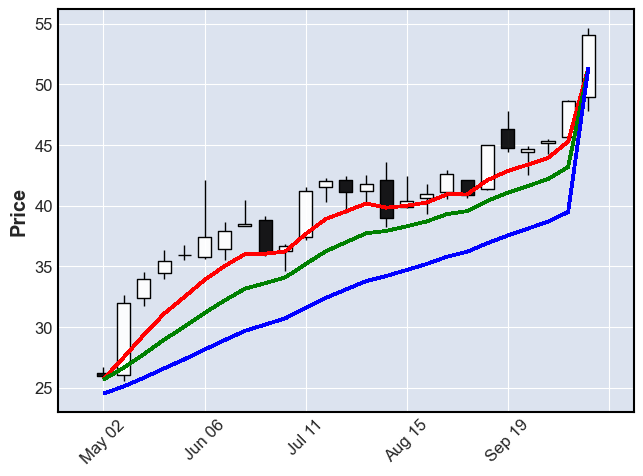

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit
In,,,,,,,,,,,
0,26.184999,26.712500,25.639999,25.965000,25.723198,25.678170,24.522185,nn,nn,2017-05-02,2.311411
1,26.084999,32.607498,25.577499,31.972500,27.508713,26.646529,25.118210,nn,nn,2017-05-09,2.311411
2,32.389999,34.555000,31.762501,34.000000,29.363366,27.777832,25.828754,nn,nn,2017-05-16,2.311411
3,34.442501,36.320000,33.927502,35.459999,31.105261,28.959704,26.599253,nn,nn,2017-05-23,2.311411
4,35.924999,36.750000,35.512501,35.910000,32.478044,30.028980,27.344113,nn,nn,2017-05-30,2.311411
5,35.744999,42.125000,35.627499,37.400002,33.884317,31.162983,28.148584,nn,nn,2017-06-06,2.311411
6,36.470001,38.692501,35.527500,37.904999,35.033084,32.200217,28.929097,nn,nn,2017-06-13,2.311411
7,38.352501,40.435001,38.305000,38.457500,36.011488,33.162876,29.691369,nn,nn,2017-06-20,2.311411
8,38.790001,39.150002,35.875000,36.139999,36.048206,33.620895,30.207260,nn,nn,2017-06-27,2.311411


In [65]:
import mplfinance as mpf
Dates = trades_df['Datetime']

if mover == 0 and switch == False:
    mover = 0
    print("Row start: ",mover) 
    print("Trade: ", 1)
    switch = True
else:
    mover += displayed_candles
    print("Row start: ",mover) 
    print("Trade: " + str(int(mover/displayed_candles)) + " (" + str(int(len(trades_df)/displayed_candles)) + ")") 

lower = mover
upper = mover + displayed_candles

selected_df = trades_df.iloc[lower:upper,:-1]
#print(selected_df)

#Get EMAs
dates = selected_df['Datetime']
ema6 = selected_df['ema6']
ema12 = selected_df['ema12']
ema24 = selected_df['ema24']
datepairs_ema6 = [(d1,d2) for d1,d2 in zip(dates,ema6)]
datepairs_ema12 = [(d1,d2) for d1,d2 in zip(dates,ema12)]
datepairs_ema24 = [(d1,d2) for d1,d2 in zip(dates,ema24)]
#datepairs_ema16

# #Format Dataframe
quotes = selected_df.iloc[:,:10]
quotes['Datetime'] = quotes['Datetime'].astype('datetime64')
quotes = quotes.set_index('Datetime')
quotes = quotes.iloc[:displayed_candles,:4]
quotes.columns=['open','high','low','close']

#Define function to get entry
EntryPriceRow = 0
def GetEntryPriceColl(candle):
    if candle == 'Previous High':
        EntryPriceColl = 1
        EntryPriceRow = 1
    if candle == 'Current Open':
        EntryPriceColl = 0
        EntryPriceRow = 0
    if candle == 'Previous Close':
        EntryPriceColl = 3
        EntryPriceRow = 1
    return EntryPriceColl, EntryPriceRow
entry_price_column,entry_price_row = GetEntryPriceColl(entry_candle)  #
# budget = 10000

entry = selected_df.iloc[window_size-1-entry_price_row,entry_price_column]
profit = selected_df.iloc[window_size-1,-1]
print(entry)
real_profit = round((budget / entry)*profit,2)
print("\nBudget: ",budget)

print("\nEntry price: ",round(entry,2))
print("Label (target): ",round(selected_df.iloc[window_size-1,7],2))
print("Model prediction: ",round(selected_df.iloc[window_size-1,8],2))
print("\nProfit: ",round(selected_df.iloc[window_size-1,-1],3))
print("Real Profit: " + str(real_profit) + " dollars (budget " + str(budget) + ")")

#two_points  = [('2018-07-31',48),('2018-08-01',49)]

mpf.plot(quotes,type='candle',alines=dict(alines=[datepairs_ema6,datepairs_ema12,datepairs_ema24],colors=['r','g','b'])) # datepairs_ema12,datepairs_ema24
#mpf.plot(quotes,type='candle')

selected_df

<b>Investigate losing trades</b>

In [66]:
selected_df

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit
In,,,,,,,,,,,
0,26.184999,26.712500,25.639999,25.965000,25.723198,25.678170,24.522185,nn,nn,2017-05-02,2.311411
1,26.084999,32.607498,25.577499,31.972500,27.508713,26.646529,25.118210,nn,nn,2017-05-09,2.311411
2,32.389999,34.555000,31.762501,34.000000,29.363366,27.777832,25.828754,nn,nn,2017-05-16,2.311411
3,34.442501,36.320000,33.927502,35.459999,31.105261,28.959704,26.599253,nn,nn,2017-05-23,2.311411
4,35.924999,36.750000,35.512501,35.910000,32.478044,30.028980,27.344113,nn,nn,2017-05-30,2.311411
5,35.744999,42.125000,35.627499,37.400002,33.884317,31.162983,28.148584,nn,nn,2017-06-06,2.311411
6,36.470001,38.692501,35.527500,37.904999,35.033084,32.200217,28.929097,nn,nn,2017-06-13,2.311411
7,38.352501,40.435001,38.305000,38.457500,36.011488,33.162876,29.691369,nn,nn,2017-06-20,2.311411
8,38.790001,39.150002,35.875000,36.139999,36.048206,33.620895,30.207260,nn,nn,2017-06-27,2.311411


In [67]:
trades_df.tail(30)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit,Trades
In,,,,,,,,,,,,
5945,267.279999,275.579987,230.619995,231.190002,249.561285,251.048273,249.480758,nn,nn,2022-04-05,2.699997,169
5946,222.139999,227.770004,211.630005,212.580002,238.995204,245.130077,246.528697,nn,nn,2022-04-12,2.699997,169
5947,212.000000,226.699997,195.000000,195.149994,226.468001,237.440834,242.418401,nn,nn,2022-04-19,2.699997,169
5948,192.020004,201.279999,182.899994,185.470001,214.754287,229.445321,237.862529,nn,nn,2022-04-26,2.699997,169
5949,185.410004,204.000000,155.669998,188.110001,183.297501,183.297501,183.297501,204.0,263.426612,2022-04-27,2.699997,169
5950,335.170013,346.470001,308.799988,315.029999,292.217610,265.134196,234.245444,nn,nn,2021-11-23,6.860001,170
5951,323.660004,334.119995,301.299988,306.929993,296.421148,271.564319,240.060207,nn,nn,2021-11-30,6.860001,170
5952,298.799988,324.489990,280.380005,301.980011,298.009394,276.243656,245.013792,nn,nn,2021-12-07,6.860001,170
5953,302.489990,311.600006,272.500000,278.010010,292.295284,276.515403,247.653489,nn,nn,2021-12-14,6.860001,170


In [68]:
raw_data = pd.read_csv('nvda_stock_raw_initial_df.csv')

In [69]:
losing_trades = trades_df[trades_df['profit']<0]
losing_trades

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit,Trades
In,,,,,,,,,,,,
600,48.950001,49.897499,48.112499,49.224998,46.409733,44.116788,40.264635,nn,nn,2017-10-17,-0.602501,9
601,49.445000,50.467499,47.792500,50.465000,47.568381,45.093436,41.080664,nn,nn,2017-10-24,-0.602501,9
602,50.465000,52.492500,50.305000,52.172501,48.883843,46.182523,41.968011,nn,nn,2017-10-31,-0.602501,9
603,51.799999,54.667500,50.092499,54.035000,50.355602,47.390596,42.933370,nn,nn,2017-11-07,-0.602501,9
604,54.035000,54.292500,51.950001,52.840000,51.065430,48.228966,43.725901,nn,nn,2017-11-14,-0.602501,9
...,...,...,...,...,...,...,...,...,...,...,...,...
5920,277.559998,289.459991,262.670013,267.119995,256.909798,254.658868,251.071258,nn,nn,2022-03-29,-25.080002,168
5921,267.279999,275.579987,230.619995,231.190002,249.561285,251.048273,249.480758,nn,nn,2022-04-05,-25.080002,168
5922,222.139999,227.770004,211.630005,212.580002,238.995204,245.130077,246.528697,nn,nn,2022-04-12,-25.080002,168


In [70]:
loss_trade = raw_data[raw_data['Date'] > "2020-09-21"]
loss_trade.head(25)

,Unnamed: 0,Date,Open,High,Low,Close,EMA6,EMA12,EMA24
1132,1132,2020-09-28,130.402496,137.627502,127.500000,130.622498,125.383554,118.524161,105.693309
1133,1133,2020-10-05,132.360001,141.419998,132.227493,137.627502,128.881825,121.463136,108.248045
1134,1134,2020-10-12,139.895004,143.485001,137.677505,138.115005,131.519877,124.024962,110.637402
1135,1135,2020-10-19,139.029999,139.835007,132.317505,135.902496,132.772054,125.852275,112.658609
1136,1136,2020-10-26,134.270004,136.927505,123.000000,125.339996,130.648609,125.773463,113.673120
1137,1137,2020-11-02,126.577499,145.887497,123.949997,145.619995,134.926148,128.826776,116.228870
1138,1138,2020-11-09,145.524994,146.914993,126.282501,132.970001,134.367249,129.464195,117.568161
1139,1139,2020-11-16,131.725006,136.494995,130.649994,130.877502,133.370178,129.681627,118.632908
1140,1140,2020-11-23,131.712494,134.074997,128.850006,132.612503,133.153700,130.132531,119.751276
1141,1141,2020-11-30,132.649994,136.735001,129.722504,135.582504,133.847644,130.970988,121.017774


<b>Create Report</b>

In [71]:
trades_df.to_csv('trades_df.csv')
trades_df = trades_df.reset_index()
#trades_df = trades_df.set_index('index')

try:
    trades_df = trades_df.drop('level_0',axis=1)
    trades_df = trades_df.drop('In',axis=1)
except:
    pass
trades_df.tail(20)

,In,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit,Trades
4230,5955,296.600006,313.299988,293.309998,294.109985,293.651466,281.810788,254.957752,nn,nn,2021-12-28,6.860001,170
4231,5956,298.149994,307.109985,270.570007,272.470001,287.599619,280.373744,256.358732,nn,nn,2022-01-04,6.860001,170
4232,5957,265.809998,285.950012,256.440002,269.420013,282.405446,278.688555,257.403634,nn,nn,2022-01-11,6.860001,170
4233,5958,262.600006,266.380005,232.630005,233.740005,268.501034,271.773393,255.510544,nn,nn,2022-01-18,6.860001,170
4234,5959,223.300003,240.570007,208.880005,228.399994,257.043594,265.100563,253.341700,nn,nn,2022-01-25,6.860001,170
4235,5960,231.820007,258.170013,230.520004,243.190002,253.085425,261.729707,252.529564,nn,nn,2022-02-01,6.860001,170
4236,5961,243.720001,269.250000,237.729996,239.490005,249.201020,258.308215,251.486399,nn,nn,2022-02-08,6.860001,170
4237,5962,239.339996,265.820007,231.000000,236.419998,245.549299,254.940797,250.281087,nn,nn,2022-02-15,6.860001,170
4238,5963,230.350006,242.169998,208.899994,241.570007,244.412359,252.883752,249.584201,nn,nn,2022-02-22,6.860001,170
4239,5964,239.919998,246.649994,224.820007,229.360001,240.111685,249.264714,247.966265,nn,nn,2022-03-01,6.860001,170


In [72]:
try:
    raw_data = raw_data.drop('Unnamed: 0',axis=1)
except:
    pass
raw_data

,Date,Open,High,Low,Close,EMA6,EMA12,EMA24
0,1999-01-18,0.437500,0.488281,0.388021,0.410156,NaN,NaN,NaN
1,1999-01-25,0.442708,0.467448,0.395833,0.395833,NaN,NaN,NaN
2,1999-02-01,0.395833,0.416667,0.360677,0.412760,NaN,NaN,NaN
3,1999-02-08,0.415365,0.437500,0.372396,0.434896,NaN,NaN,NaN
4,1999-02-15,0.442708,0.460938,0.393229,0.434896,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1216,2022-05-09,180.339996,182.550003,155.669998,177.059998,198.269329,215.828070,229.236444
1217,2022-05-16,175.089996,183.710007,157.550003,166.940002,189.318093,208.306829,224.252729
1218,2022-05-23,162.740005,188.809998,157.800003,188.110001,188.972924,205.199624,221.361311
1219,2022-05-30,189.800003,196.190002,181.220001,187.199997,188.466373,202.430451,218.628406


In [73]:
trades_df.head()
entry_candle

'Current Open'

In [74]:
performance_report = trades_df.copy()

# def Get_hold_period(df,date_from,profit):
#     period = 0
    
#     if profit < 0:
#         condition = df['Date'] == date_from
#         sorted_df = df[condition]
#         print(sorted_df)
#         st_temp = sorted_df.reset_index()
#         first_boundary = st_temp.loc[0,'index']
#         c = 0
#         period = 0
#         while c < 5:
#             c += 1
#             print(raw_data.loc[first_boundary+c,'High'])
#             target = raw_data.loc[first_boundary+c,'High']

#             if target != entry:
#                 period = c
#                 break

#     return period

def profit_calculation(difference,stock_price,budget):
    qty = round(budget/stock_price,0)
    
    return round(difference * qty)

EntryPriceRow = 0
def GetEntryPriceColl(candle):
    if candle == 'Previous High':
        EntryPriceColl = 'high'
        EntryPriceRow = 1
    if candle == 'Current Open':
        EntryPriceColl = 'opens'
        EntryPriceRow = 0
    if candle == 'Previous Close':
        EntryPriceColl = 'close'
        EntryPriceRow = 1
    return EntryPriceColl, EntryPriceRow

entry_coll, entry_row = GetEntryPriceColl(entry_candle) #

budget = 10000

for row in range(24,len(performance_report),25):
    #Get data items
    #print(row)
    #print(performance_report.loc[row-1,'high'])
    entry = performance_report.loc[row-entry_row,entry_coll]
    difference = performance_report.loc[row,'profit']
    prediction = performance_report.loc[row,'prediction']
    ent_date = performance_report.loc[row-1,'Datetime']
    
    #Fill data
    performance_report.loc[row,'Entry'] = entry
    performance_report.loc[row,'Performance'] = profit_calculation(difference,entry,budget)
    #performance_report.loc[row,'Holding period'] = Get_hold_period(raw_data,ent_date,difference)
    
performance_report = performance_report.fillna("nn")

<b>Reorder columns</b>

In [75]:
performance_report = performance_report[['Datetime', 'opens', 'high', 'low','close','ema6','ema12','ema24','Entry','labels','prediction','profit','Performance','Trades']]

In [76]:
performance_report.tail(26)

,Datetime,opens,high,low,close,ema6,ema12,ema24,Entry,labels,prediction,profit,Performance,Trades
4224,2022-04-27,185.410004,204.000000,155.669998,188.110001,183.297501,183.297501,183.297501,185.410004,204.0,263.426612,2.699997,146.0,169
4225,2021-11-23,335.170013,346.470001,308.799988,315.029999,292.217610,265.134196,234.245444,nn,nn,nn,6.860001,nn,170
4226,2021-11-30,323.660004,334.119995,301.299988,306.929993,296.421148,271.564319,240.060207,nn,nn,nn,6.860001,nn,170
4227,2021-12-07,298.799988,324.489990,280.380005,301.980011,298.009394,276.243656,245.013792,nn,nn,nn,6.860001,nn,170
4228,2021-12-14,302.489990,311.600006,272.500000,278.010010,292.295284,276.515403,247.653489,nn,nn,nn,6.860001,nn,170
4229,2021-12-21,273.049988,300.589996,271.450012,296.399994,293.468059,279.574571,251.553210,nn,nn,nn,6.860001,nn,170
4230,2021-12-28,296.600006,313.299988,293.309998,294.109985,293.651466,281.810788,254.957752,nn,nn,nn,6.860001,nn,170
4231,2022-01-04,298.149994,307.109985,270.570007,272.470001,287.599619,280.373744,256.358732,nn,nn,nn,6.860001,nn,170
4232,2022-01-11,265.809998,285.950012,256.440002,269.420013,282.405446,278.688555,257.403634,nn,nn,nn,6.860001,nn,170
4233,2022-01-18,262.600006,266.380005,232.630005,233.740005,268.501034,271.773393,255.510544,nn,nn,nn,6.860001,nn,170


In [77]:
# performance_report.to_csv('nvda_80_performance_report.csv')

In [78]:
performance_report.to_excel('nvda_80_performance_report.xlsx')